In [2]:
import os
import pandas as pd
import numpy as np
import sklearn as sk
import warnings
import itertools as IT
import glob
import datetime as dt
import time
import sys

sys.path.insert(0, '/data/aithe/data/customercube/code/common/')
# import common_path
from dateutil.relativedelta import relativedelta

# from xgboost import plot_importance
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV   #Perforing grid search

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import xgboost

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)
pd.set_option('max_info_columns',500)
pd.set_option('display.float_format', lambda x : '%.3f' % x )



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
data=pd.read_csv("PJT002_train.csv",encoding="UTF-8-sig")

data.shape

(59199, 180)

In [4]:
print('NON RETURN', round(data['fr_yn'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('RETURN', round(data['fr_yn'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

X = data.drop('fr_yn', axis=1)
y = data['fr_yn']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

NON RETURN 87.07 % of the dataset
RETURN 12.93 % of the dataset
Train: [11653 11654 11655 ... 59196 59197 59198] Test: [    0     1     2 ... 12779 12786 12791]
Train: [    0     1     2 ... 59196 59197 59198] Test: [11653 11654 11655 ... 27866 27869 27879]
Train: [    0     1     2 ... 59196 59197 59198] Test: [23132 23133 23134 ... 40962 40968 40980]
Train: [    0     1     2 ... 59196 59197 59198] Test: [34787 34788 34789 ... 51751 51753 51755]
Train: [    0     1     2 ... 51751 51753 51755] Test: [46538 46539 46540 ... 59196 59197 59198]


In [5]:
# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.87065034 0.12934966]
[0.87068165 0.12931835]


In [5]:
for col in data:
    if data[col].dtype =='object':
        print(data[col].unique(),col)

['2017-10-20 05:54' '2018-09-30 08:26' '2016-10-30 14:57' ...
 '2018-03-03 19:49' '2017-09-27 11:10' '2015-09-20 07:34'] dt_of_fr
['Y' 'N'] fr_yn
['단독주택' nan '공동주택' '종교시설' '공장' '제1종근린생활시설' '숙박시설' '동.식물 관련시설' '창고시설'
 '제2종근린생활시설' '문화및집회시설' '자동차관련시설' '업무시설' '판매시설' '교육연구시설' '분뇨.쓰레기처리시설'
 '수련시설' '의료시설' '노유자시설' '운동시설' '위락시설' '위험물저장및처리시설' '공공용시설' '교정및군사시설'
 '교육연구및복지시설' '장례식장' '운수시설' '관광휴게시설' '근린생활시설' '시장' '방송통신시설' '묘지관련시설' '발전시설'
 '판매및영업시설' '파출소'] bldng_us
['블록구조' nan '철근콘크리트구조' '일반목구조' '벽돌구조' '경량철골구조' '일반철골구조' '철골콘크리트구조' '통나무구조'
 '강파이프구조' '목구조' '석구조' '조적구조' '기타강구조' '철골철근콘크리트구조' '기타구조' '기타조적구조'
 '프리케스트콘크리트구조' '기타콘크리트구조'] bldng_archtctr
[1977.0 nan 20001104.0 ... 20040914.0 19880624.0 20120327.0] dt_of_athrztn
['주거용' nan '상업용' '문교사회용' '공업용' '농수산용' '기타' '공공용'] bldng_us_clssfctn
['대' '답' '임' '종' '장' '전' '잡' '목' '도' '천' '양' '구' '과' '체' '창' '학' '원' '공'
 '유' '수' '주' '철' '묘' '제' '차' '사'] jmk
['자연녹지지역' '계획관리지역' '제2종일반주거지역' '제1종일반주거지역' '자연환경보전지역' '보전관리지역' '일반상업지역'
 '생산관리지역' '준주거지역' '생산녹지지역' '농림지역' nan

for col in data:
    try:
        if data[col].dtype !='object':
            sns.distplot(data[col],label=col)
            plt.show()
    except ValueError:
        pass
data.info()

In [ ]:
for col in data:
    if data[col].dtype=="object":
        print(data[col].describe())
        print("#############################################")

In [ ]:
결측치없는칼럼=list(data.isnull().sum()[data.isnull().sum()==0].index)
결측치있는칼럼=list(data.isnull().sum()[data.isnull().sum()!=0].index)

In [ ]:
data.loc[:,data.dtypes=="object"]

data.groupby("bldng_us").count().sort_values("dt_of_fr",ascending=False)

In [ ]:
for col in data:
    if data[col].dtype=="int64":
        print(data[col].describe())
        sns.distplot(data[col])
        plt.show()
        print("#############################################")

## OBJECT 타입 데이터 칼럼부터 다듬기

In [8]:
object_list=[]
for col in data:
    if data[col].dtype =="object":
        object_list.append(col)
    

In [9]:
object_data=data[object_list[:]]

numeric_data=list(set(data.columns.tolist()) - set(object_list))
numeric_data=sorted(numeric_data)

In [10]:
object_data['dt_of_fr']=object_data['dt_of_fr'].astype('datetime64[ns]')

In [11]:
object_data.fr_yn=object_data.fr_yn.apply(lambda x: 1 if x=="Y" else 0)

In [12]:
object_data.bldng_us.unique()

array(['단독주택', nan, '공동주택', '종교시설', '공장', '제1종근린생활시설', '숙박시설',
       '동.식물 관련시설', '창고시설', '제2종근린생활시설', '문화및집회시설', '자동차관련시설', '업무시설',
       '판매시설', '교육연구시설', '분뇨.쓰레기처리시설', '수련시설', '의료시설', '노유자시설', '운동시설',
       '위락시설', '위험물저장및처리시설', '공공용시설', '교정및군사시설', '교육연구및복지시설', '장례식장',
       '운수시설', '관광휴게시설', '근린생활시설', '시장', '방송통신시설', '묘지관련시설', '발전시설',
       '판매및영업시설', '파출소'], dtype=object)

In [13]:
object_data['주거시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="단독주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x=="공동주택" else x)
object_data['주거시설YN']=object_data.주거시설YN.apply(lambda x: 1 if x==1 else 0)



In [14]:
object_data['편의시설YN']=object_data.bldng_us.apply(lambda x: 1 if x=="제1종근린생활시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="제2종근린생활시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x=="문화및집회시설" else x)

object_data['편의시설YN']=object_data.편의시설YN.apply(lambda x: 1 if x==1 else 0)

In [15]:
object_data.groupby("bldng_us").size().sort_values(ascending=False)

bldng_us
단독주택          20232
제1종근린생활시설      2350
제2종근린생활시설      2262
창고시설           1513
동.식물 관련시설      1467
공장             1179
공동주택            941
숙박시설            262
노유자시설           205
교육연구시설          185
종교시설            161
업무시설            131
자동차관련시설         119
위험물저장및처리시설      115
분뇨.쓰레기처리시설       55
판매시설             52
운동시설             42
문화및집회시설          38
위락시설             35
근린생활시설           31
관광휴게시설           30
의료시설             27
교육연구및복지시설        18
수련시설             15
운수시설             12
발전시설             11
방송통신시설           11
묘지관련시설            9
교정및군사시설           7
장례식장              3
판매및영업시설           1
시장                1
파출소               1
공공용시설             1
dtype: int64

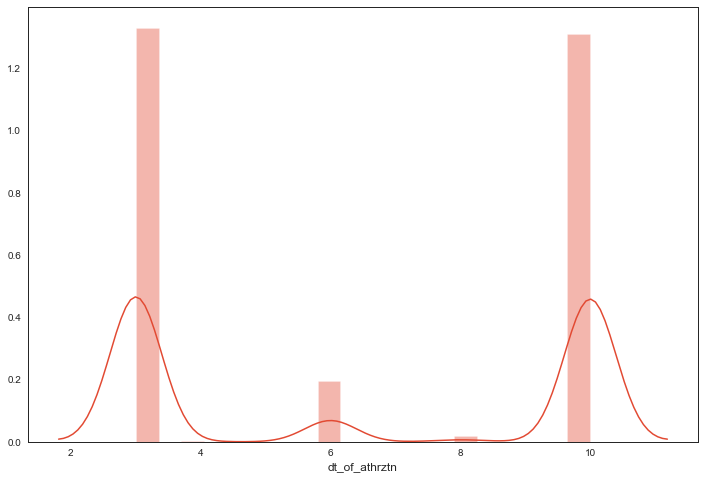

In [16]:
# 6자리 혹은 nan 혹은 10자리임을 알 수 있음.
sns.distplot(object_data.dt_of_athrztn.astype(str).apply(len))

In [17]:
'dssds'[0:4]

'dssd'

In [18]:
object_data.dt_of_athrztn=object_data.dt_of_athrztn.apply(lambda x: str(x)[0:4] if len(str(x))==10 else x)

In [19]:
object_data.dt_of_athrztn=object_data.dt_of_athrztn.apply(lambda x: str(x)[0:4] if len(str(x))==6 else x)

In [21]:
object_data['목재구조YN']=object_data.bldng_archtctr.apply(lambda x: 1 if x=="일반목구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x=="통나무구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x=="목구조" else x)
object_data['목재구조YN']=object_data.목재구조YN.apply(lambda x: 1 if x==1 else 0)

In [22]:
object_data.bldng_us_clssfctn.unique()

object_data.groupby("bldng_us_clssfctn").size().sort_values(ascending=False)

object_data['주거용YN']=object_data.bldng_us_clssfctn.apply(lambda x: 1 if x=="주거용" else 0)

In [25]:
object_data.jmk.unique()

array(['대', '답', '임', '종', '장', '전', '잡', '목', '도', '천', '양', '구', '과',
       '체', '창', '학', '원', '공', '유', '수', '주', '철', '묘', '제', '차', '사'],
      dtype=object)

In [35]:
빌딩결측분류_인덱스=object_data.bldng_us[object_data.bldng_us_clssfctn.isna()].index

In [42]:
object_data.bldng_us.unique()

array(['단독주택', nan, '공동주택', '종교시설', '공장', '제1종근린생활시설', '숙박시설',
       '동.식물 관련시설', '창고시설', '제2종근린생활시설', '문화및집회시설', '자동차관련시설', '업무시설',
       '판매시설', '교육연구시설', '분뇨.쓰레기처리시설', '수련시설', '의료시설', '노유자시설', '운동시설',
       '위락시설', '위험물저장및처리시설', '공공용시설', '교정및군사시설', '교육연구및복지시설', '장례식장',
       '운수시설', '관광휴게시설', '근린생활시설', '시장', '방송통신시설', '묘지관련시설', '발전시설',
       '판매및영업시설', '파출소'], dtype=object)

In [36]:
object_data.bldng_us_clssfctn.unique()

array(['주거용', nan, '상업용', '문교사회용', '공업용', '농수산용', '기타', '공공용'],
      dtype=object)

In [44]:
object_data.groupby("bldng_us_clssfctn").size()

bldng_us_clssfctn
공공용         34
공업용       1043
기타        1899
농수산용      1225
문교사회용      677
상업용       5389
주거용      19589
dtype: int64

In [41]:
object_data.bldng_us.apply(lambda x: "주거용" if x =="대" else x)
object_data.bldng_us.apply(lambda x: "상업용" if x =="대" else x)
object_data.bldng_us.apply(lambda x: "주거용" if x =="대" else x)
object_data.bldng_us.apply(lambda x: "주거용" if x =="대" else x)


0        주거용
1        NaN
2        주거용
3        주거용
4        NaN
        ... 
59194    NaN
59195    NaN
59196    NaN
59197    상업용
59198     기타
Name: bldng_us_clssfctn, Length: 59199, dtype: object

In [20]:
object_data.sample(10)

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,dt_of_athrztn,bldng_us_clssfctn,jmk,rgnl_ar_nm,rgnl_ar_nm2,lnd_us_sttn_nm,rd_sd_nm,emd_nm,mlt_us_yn,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn,주거시설YN,편의시설YN
27478,2018-03-30 23:07:00,0,제1종근린생활시설,철근콘크리트구조,1992,상업용,대,제2종일반주거지역,지정되지않음,주상기타,세로각지(가),경상남도 진주시 초장동,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
31451,2015-07-30 18:47:00,0,NaN,NaN,NaN,NaN,대,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 의령군 봉수면,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
25928,2015-01-16 07:39:00,0,NaN,NaN,NaN,NaN,대,일반상업지역,지정되지않음,단독,세로한면(불),경상남도 창원시마산합포구 오동동,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
39454,2014-04-27 20:14:00,0,NaN,NaN,NaN,NaN,대,계획관리지역,지정되지않음,단독,세로한면(불),경상남도 진주시 수곡면,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3485,2015-04-11 04:19:00,0,단독주택,벽돌구조,1996,주거용,대,계획관리지역,지정되지않음,단독,세로각지(가),경상남도 남해군 창선면,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
35435,2016-03-24 19:46:00,1,단독주택,경량철골구조,1996,주거용,전,농림지역,지정되지않음,전,세로한면(가),경상남도 함양군 함양읍,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
27276,2016-01-14 10:37:00,0,단독주택,벽돌구조,1990,주거용,대,일반상업지역,지정되지않음,단독,세로한면(불),경상남도 진주시 성북동,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
24544,2017-02-18 18:03:00,0,단독주택,일반목구조,1951,NaN,대,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 창녕군 창녕읍,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
51873,2015-06-18 10:41:00,0,단독주택,일반목구조,2005,주거용,대,계획관리지역,지정되지않음,주거기타,세로한면(가),경상남도 거제시 일운면,N,펜션7실이하,N,N,N,N,N,N,N,1,0
38371,2018-12-29 04:35:00,0,NaN,NaN,NaN,NaN,대,계획관리지역,지정되지않음,단독,세로각지(가),경상남도 남해군 삼동면,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
